# **Importing the libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# **Importing the dataset**

In [2]:
dataset = pd.read_csv('used_cars.csv')

In [3]:
dataset.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


# **Cleaning the dataset**

In [4]:
dataset['milage'] = dataset['milage'].str.replace(' mi.', '', regex=False).str.replace(',', '').astype(float)
dataset['price'] = dataset['price'].str.replace('$', '', regex=False).str.replace(',', '').astype(float)

In [5]:
dataset = dataset[['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
         'transmission', 'accident', 'clean_title', 'price']].dropna()

# **Feature Engineering**

In [6]:
dataset['age'] = 2025 - dataset['model_year']
dataset['milage_per_year'] = dataset['milage'] / dataset['age']
dataset['engine_hp'] = dataset['engine'].str.extract(r'(\d+(?:\.\d+)?)HP')[0].astype(float)
dataset['engine_liters'] = dataset['engine'].str.extract(r'(\d+(?:\.\d+)?)L')[0].astype(float)

# **Removing outliers**

In [7]:
dataset = dataset[dataset['price'] < 150000]
dataset = dataset.drop(columns=['engine'])

# **Defining Features and Target**

In [8]:
X = dataset.drop(columns=['price'])
y = dataset['price']

# **Encoding the categorical variables**

In [9]:
categorical_cols = ['brand', 'model', 'fuel_type', 'transmission', 'accident', 'clean_title']
numerical_cols = ['model_year', 'milage', 'age', 'milage_per_year', 'engine_hp', 'engine_liters']

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('num', SimpleImputer(strategy='median'), numerical_cols)
    ]
)

# **Building the pipeline**

In [11]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)

In [12]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', xgb_model)])

# **Splitting the dataset into training and test set**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Training the Model on the pipeline**

In [14]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['brand', 'model',
                                                   'fuel_type', 'transmission',
                                                   'accident', 'clean_title']),
                                                 ('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['model_year', 'milage',
                                                   'age', 'milage_per_year',
                                                   'engine_hp',
                                                   'engine_liters'])])),
                ('regressor',
                 XGBRegressor(bas...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

# **Predicting the Test Set results**

In [15]:
y_pred = pipeline.predict(X_test)
comparison = np.concatenate((y_pred.reshape(-1, 1), y_test.to_numpy().reshape(-1, 1)), axis=1)
comparison_dataset = pd.DataFrame(comparison, columns=['Predicted', 'Actual'])
comparison_dataset = comparison_dataset.round(2)
print(comparison_dataset.head(20))

    Predicted   Actual
0    73790.50  70000.0
1     8962.34  17900.0
2    12164.31  11500.0
3    24791.61  20995.0
4    77279.84  84000.0
5    33530.45  27800.0
6    63336.90  49999.0
7    58275.39  51500.0
8    13890.64  10900.0
9    19524.82  24000.0
10    8655.15   7500.0
11   11782.24  14500.0
12   29377.45  16800.0
13   70779.62  68495.0
14   17691.80  20999.0
15   23973.96  17000.0
16    9446.97   4000.0
17   28088.42  27500.0
18   42608.38  53722.0
19   44326.58  79990.0


# **Evaluating the model**

In [16]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [17]:
print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"Mean Squared Error (MSE): ${mse:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): $7,149.06
Mean Squared Error (MSE): $129,309,624.38
Root Mean Squared Error (RMSE): $11,371.44
R² Score: 0.8177


# **Visualizing the results**

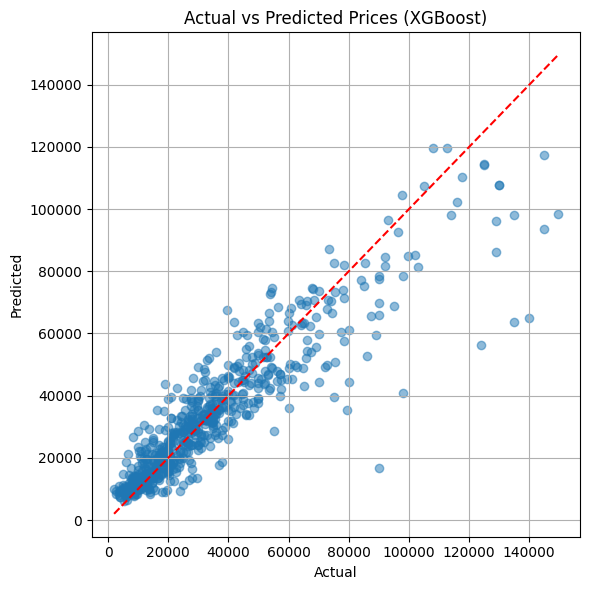

In [18]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Prices (XGBoost)')
plt.grid(True)
plt.tight_layout()
plt.show()

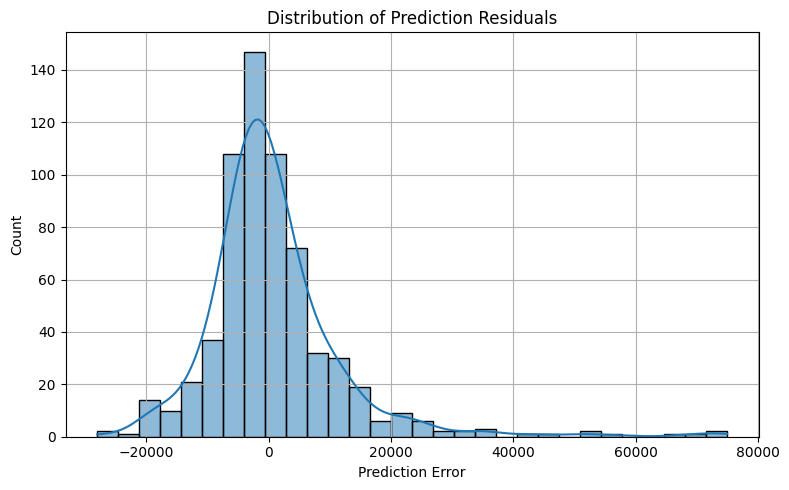

In [19]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Distribution of Prediction Residuals')
plt.xlabel('Prediction Error')
plt.grid(True)
plt.tight_layout()
plt.show()